In [20]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline

In [2]:
app = pd.read_pickle('app_cleaned.pickle')

In [3]:
app = app.drop_duplicates()

In [13]:
app = app.dropna(axis = 0)#remove the NAN

In [14]:
app.T

,0,2,3,4,5,10,13,14,16,17,...,5645,5646,5647,5648,5649,5651,5653,5654,5655,5656
category,Finance,Finance,Finance,Finance,Finance,Finance,Finance,Finance,Finance,Finance,...,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities
current_rating,1.8,4.64497,2.16667,4.60773,4.34066,4.50365,3.27559,4.28226,1.90909,4.55813,...,4.70536,3.13636,4.61827,4.80667,4.46042,3.24093,3.75904,4.54294,3.97506,3.1519
description,The JPay App lets you send money and email to ...,Access your interactive Experian Credit Report...,Use the Vanguard app to check your accounts an...,Conveniently manage your credit card account f...,Be the first to know about news and market mov...,"Take control of your tax life, year round. Wit...",Pocket Expense is a full-featured finance soft...,HERES YOUR MONEY APP View all your accounts in...,"View account balances, make payments and trans...",Know your credit score and much more Capital O...,...,iHandy Level (one of the 5 tools of iHandy Car...,Flashlight goes way beyond the standard white ...,Tap into the largest collection of live police...,"Use Speedtest for a quick, easy, one-tap conne...","Bringing you free texting, free picture messag...",Theres a faster way with our cleaner and more ...,The most simple & easy QR Reader - 100% FREE. ...,Bright. Fast. Simple. The most elegant and fun...,Browse fast on your iPhone and iPad with the G...,Bitmoji is your own personal emoji. Create an...
id,584959322,1087101090,335186209,1128712763,552799694,490111274,424575621,602710567,995112030,1008234539,...,299852753,285281827,356336433,300704847,314487667,309172177,368494609,381471023,535886823,868077558
is_InAppPurcased,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
is_multilingual,0,0,0,0,0,0,1,0,0,0,...,1,0,1,1,1,1,1,1,1,1
is_multiplatform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
name,JPay,Experian - Free Credit Report,Vanguard,Credit One Bank Mobile,Seeking Alpha Portfolio,My Block,Pocket Expense - Personal Finance Assistant,"Prosper Daily - Money Tracking, Free Credit Score",U by BB&T,Capital One CreditWise - Free credit score,...,iHandy Level Free,Flashlight.,5-0 Radio Police Scanner,Speedtest by Ookla,textPlus: Free SMS Texting & Calling App,myAT&T,QR Reader for iPhone,Flashlight Ⓞ,Google Chrome – The Fast and Secure Web Browser,Bitmoji - Your Personal Emoji
new_version_desc,This update has a big new feature for the new ...,Bug fixes and other minor updates,See what's new! Have an IRA? Watch your progr...,- Ability add an additional account if qualifi...,Performance improvements,Updates for the 2017 tax season.,The recent update changed some logics of data ...,New feature! Credit Card Optimizer helps you m...,Deposit more with increased mobile check depos...,Review your credit report from TransUnion to l...,...,- Design updates & performance improvement for...,"* Updated for the newer, bigger phones * Now i...",Revamped player interface - You can now choose...,This is primarily a bug fix release. If you re...,Show us some love with our new Valentine's Day...,We fixed some bugs that were causing stability...,- Compatible with iOS10 - Minor bug fixes **If...,- Fully compatible with iOS 10 now. - Increase...,Scan a QR code or barcode by using 3D Touch on...,* Includes a fix for keyboard crashing issue *...
num_current_rating,20,169,30,724,91,274,127,248,22,43,...,896,88,6392,450,139,1241,83,652,441,158


In [15]:
ratio = app['num_current_rating']/app['num_overall_rating']

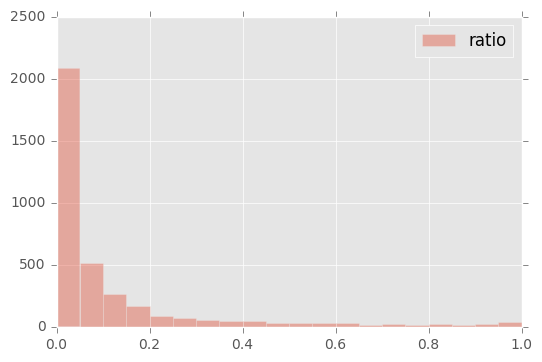

In [21]:
#use histogram to show the range of ratio
plt.hist(ratio,bins = 20, alpha = .4, label = 'ratio')
plt.legend()
plt.show()

according to the histogram, the ratios are mainly under 0.2.

In [43]:
index = ratio>0.05#get the index of ratio larger than 0.05

In [44]:
appfilter = app.loc[index]#filter the apps which number of current rating over number of overall rating larger than 0.1

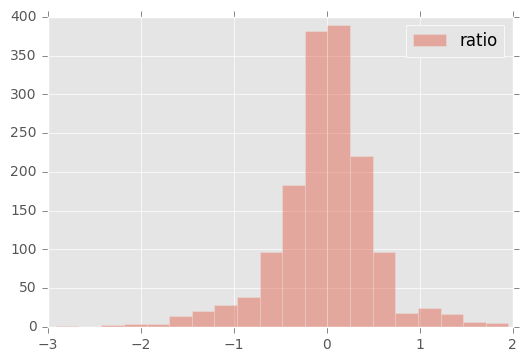

In [46]:
#use histogram to show the range of current_rating-overall_rating
plt.hist(appfilter['current_rating']-appfilter['overall_rating'],bins = 20, alpha = .4, label = 'ratio')
plt.legend()
plt.show()

In [47]:
diff = appfilter['current_rating']-appfilter['overall_rating']

In [54]:
index2 = diff>=0.1#get the index of the difference larger than 0.1

In [55]:
appinprove = appfilter.loc[index2]

In [63]:
nvd = appinprove['new_version_desc']

In [70]:
#compile documents
doc_complete = nvd.tolist()

In [81]:
#clean doc
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize
stop = stopwords.words('english')+list(string.punctuation)+['we']
def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens if w not in stop]
def lemmatize(text):
    return stem(tokenize(text))

In [82]:
doc_clean = [lemmatize(doc) for doc in doc_complete]

In [83]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [84]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [85]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.079*"fix" + 0.062*"bug" + 0.035*"improv"'), (1, u'0.020*"new" + 0.014*"io" + 0.014*"updat"'), (2, u'0.016*"app" + 0.013*"updat" + 0.010*"review"')]


In [94]:
index_io = []
for i in range(len(doc_clean)):
    if 'io' in doc_clean[i]:
        index_io.append(True)
    else:
        index_io.append(False)

In [97]:
nvd[index_io].head()

28     Version 2.6.1 of Spending Tracker  ===========...
159                                  Optimized For iOS 7
192    UPDATES: 1) Hundreds of Free TV Shows are now ...
211    iOS9 maintenance release.    - Optimized for i...
268                   - Bugs Fix - Optimised for iOS 6,7
Name: new_version_desc, dtype: object

In [98]:
index_app = []
for i in range(len(doc_clean)):
    if 'app' in doc_clean[i]:
        index_app.append(True)
    else:
        index_app.append(False)

In [105]:
nvd[index_app].head()

25     Easily fulfill money requests (and more)! Now ...
43     - Check Deposit Now Includes Automatic Image C...
106    - Order Online feature now available inside th...
129                           - General app improvements
171    Minor fixes. Thank you for helping us reach ov...
Name: new_version_desc, dtype: object

In [106]:
index_review = []
for i in range(len(doc_clean)):
    if 'review' in doc_clean[i]:
        index_review.append(True)
    else:
        index_review.append(False)

In [110]:
nvd[index_review].head()

u"-Fix unsupported authentication provider error when logging in with Google accounts As always, if you're enjoying the app, please consider leaving a nice review. It really helps and lets me know that I should continue working on this app. If you have previously left a review, please note that reviews are cleared after every update. And if you're having any issues or have any feature requests, please let me know. Contact me (Adrien) at adrien.truong@me.com. I'm always looking to improve the app."

In [ ]:
#1.fix bugs
#2.optimized for ios system
#3.app have new features
#4.reviews help app improve